In [1532]:
#importing required libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

import sklearn
from sklearn.model_selection import train_test_split,GridSearchCV
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import Ridge,Lasso
from sklearn.metrics import r2_score

from jupyterthemes import jtplot

In [1533]:
#to ignore warnings, if any.
import warnings
warnings.filterwarnings("ignore")

In [1534]:
#setting plot style using jupyter themes
def customPlot():
    jtplot.style(theme='monokai', context='notebook', ticks=True, grid=False)

In [1535]:
#using pandas for reading data from csv file 
house_data = pd.read_csv("train.csv")
house_data.head()

,Id,MSSubClass,MSZoning,LotFrontage,LotArea,Street,Alley,LotShape,LandContour,Utilities,...,PoolArea,PoolQC,Fence,MiscFeature,MiscVal,MoSold,YrSold,SaleType,SaleCondition,SalePrice
0,1,60,RL,65.00,8450,Pave,NaN,Reg,Lvl,AllPub,...,0,NaN,NaN,NaN,0,2,2008,WD,Normal,208500
1,2,20,RL,80.00,9600,Pave,NaN,Reg,Lvl,AllPub,...,0,NaN,NaN,NaN,0,5,2007,WD,Normal,181500
2,3,60,RL,68.00,11250,Pave,NaN,IR1,Lvl,AllPub,...,0,NaN,NaN,NaN,0,9,2008,WD,Normal,223500
3,4,70,RL,60.00,9550,Pave,NaN,IR1,Lvl,AllPub,...,0,NaN,NaN,NaN,0,2,2006,WD,Abnorml,140000
4,5,60,RL,84.00,14260,Pave,NaN,IR1,Lvl,AllPub,...,0,NaN,NaN,NaN,0,12,2008,WD,Normal,250000


In [1536]:
#shape of given loan data (1460 rows and 81 cloumns)
house_data.shape

(1460, 81)

In [1537]:
#loan data info
house_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1460 entries, 0 to 1459
Data columns (total 81 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   Id             1460 non-null   int64  
 1   MSSubClass     1460 non-null   int64  
 2   MSZoning       1460 non-null   object 
 3   LotFrontage    1201 non-null   float64
 4   LotArea        1460 non-null   int64  
 5   Street         1460 non-null   object 
 6   Alley          91 non-null     object 
 7   LotShape       1460 non-null   object 
 8   LandContour    1460 non-null   object 
 9   Utilities      1460 non-null   object 
 10  LotConfig      1460 non-null   object 
 11  LandSlope      1460 non-null   object 
 12  Neighborhood   1460 non-null   object 
 13  Condition1     1460 non-null   object 
 14  Condition2     1460 non-null   object 
 15  BldgType       1460 non-null   object 
 16  HouseStyle     1460 non-null   object 
 17  OverallQual    1460 non-null   int64  
 18  OverallC

In [1538]:
#supressing the float format to 2 decimal points globally
pd.options.display.float_format = '{:.2f}'.format

In [1539]:
#creating a copy of actual data
house_data_1 = house_data.iloc[:]

# **Data Cleaning**
## - Fix Null Values

In [1540]:
#list of null values
house_data_1.isna().sum()

Id                 0
MSSubClass         0
MSZoning           0
LotFrontage      259
LotArea            0
                ... 
MoSold             0
YrSold             0
SaleType           0
SaleCondition      0
SalePrice          0
Length: 81, dtype: int64

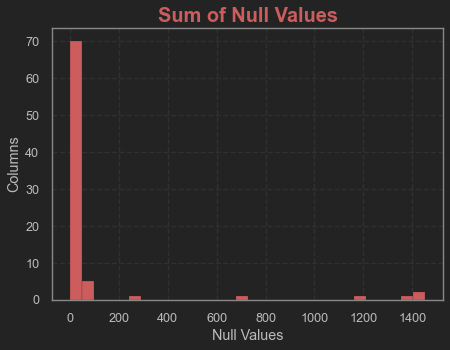

In [1541]:
#histogram for columns with null values

ax = house_data_1.isna().sum().hist(figsize=(7, 5), bins=30, color='indianred') #plotting sum of loan data null values
ax.grid(linestyle='--') #plot grid customization
plt.xlabel('Null Values') #xlabel
plt.ylabel('Columns') #ylabel
plt.title('Sum of Null Values', color='indianred', fontdict={'size': 20, 'weight': 'bold'}) #title
plt.show() #to show the plot

**Observation:**
In the above plot,
- <code>Histogram Overview:</code> There is a huge spike at 0 to 200 range and some values at different places also. So, Getting rid of Null Values > 0


In [1542]:
#percentage of null values for 19 columns
round(100 * house_data_1.isna().sum()/len(house_data_1.index),2).sort_values(ascending=0)[:19]

PoolQC         99.52
MiscFeature    96.30
Alley          93.77
Fence          80.75
FireplaceQu    47.26
LotFrontage    17.74
GarageYrBlt     5.55
GarageCond      5.55
GarageType      5.55
GarageFinish    5.55
GarageQual      5.55
BsmtFinType2    2.60
BsmtExposure    2.60
BsmtQual        2.53
BsmtCond        2.53
BsmtFinType1    2.53
MasVnrArea      0.55
MasVnrType      0.55
Electrical      0.07
dtype: float64

**Observation:**
In the above percentage of null values,
1. <code>PoolQC</code> has the highest missing values.
2. This cannot be used for the prediction.
3. Hence, remove the <code>PoolQC</code> and <code>PoolArea</code>.

In [1543]:
#drop unnecessary columns
house_data_1.drop(['PoolQC', 'PoolArea'], 1, inplace=True)

#shape after dropping unnecessary columns (1460 rows, 79 columns)
house_data_1.shape

(1460, 79)

In [1544]:
house_data_1['MiscFeature'].value_counts()

Shed    49
Gar2     2
Othr     2
TenC     1
Name: MiscFeature, dtype: int64

**Observation:**
In the above MiscFeature Value Counts,
1. <code>Shed</code> has the highest values.
2. Other categories cannot be used for the prediction.
3. Hence, create <code>Shed</code> column and remove the <code>MiscFeature</code>.

In [1545]:
#create true and false using Shed
house_data_1['Shed'] = np.where(house_data_1['MiscFeature'] == 'Shed', 1, 0)

#drop unnecessary columns
house_data_1.drop(['MiscFeature'], 1, inplace=True)

#shape after dropping unnecessary columns (1460 rows, 79 columns)
house_data_1.shape

(1460, 79)

In [1546]:
#round the null values
rounding = round(house_data_1.isna().sum()/len(house_data_1.index),2)

#filtered columns with null values > 15%
null_cols = rounding[rounding.values>0.10].index.tolist()

#drop columns with null values > 15%
house_data_1.drop(columns=null_cols, inplace=True)

#shape after dropping the columns with null values (1460 rows, 75 Columns)
house_data_1.shape

(1460, 75)

In [1547]:
#percentage of null values for 13 columns
round(100 * house_data_1.isna().sum()/len(house_data_1.index),2).sort_values(ascending=0)[:13]

GarageType     5.55
GarageCond     5.55
GarageYrBlt    5.55
GarageFinish   5.55
GarageQual     5.55
BsmtFinType2   2.60
BsmtExposure   2.60
BsmtFinType1   2.53
BsmtCond       2.53
BsmtQual       2.53
MasVnrArea     0.55
MasVnrType     0.55
Electrical     0.07
dtype: float64

In [1548]:
#sum of null values
missing_values = house_data_1.isnull().sum()
missing_values[missing_values != 0].sort_values(ascending=0)

GarageType      81
GarageYrBlt     81
GarageFinish    81
GarageQual      81
GarageCond      81
BsmtExposure    38
BsmtFinType2    38
BsmtQual        37
BsmtCond        37
BsmtFinType1    37
MasVnrType       8
MasVnrArea       8
Electrical       1
dtype: int64

In [1549]:
#filling the missing values 'BsmtFinType1', 'BsmtFinType2', 'BsmtExposure', 'BsmtQual','BsmtCond'
Columns_basement = ['BsmtFinType1', 'BsmtFinType2', 'BsmtExposure', 'BsmtQual', 'BsmtCond']
for i in Columns_basement:
    house_data_1[i] = house_data_1[i].fillna('No Basement')

#filling the missing values in 'GarageType', 'GarageFinish', 'GarageQual', 'GarageCond'
Columns_Garage = ['GarageType', 'GarageFinish', 'GarageQual', 'GarageCond']
for i in Columns_Garage:
    house_data_1[i] = house_data_1[i].fillna('No Garage')

In [1550]:
#sum of null values
missing_values = house_data_1.isnull().sum()
missing_values[missing_values != 0].sort_values(ascending=0)

GarageYrBlt    81
MasVnrType      8
MasVnrArea      8
Electrical      1
dtype: int64

In [1551]:
house_data_1['GarageYrBlt'] = house_data_1['GarageYrBlt'].fillna(0)
house_data_1['MasVnrArea'] = house_data_1['MasVnrArea'].fillna(0)
house_data_1['MasVnrArea'] = house_data_1['MasVnrArea'].fillna(0)
house_data_1['Electrical'] = house_data_1['Electrical'].fillna("Other")
house_data_1['MasVnrType'] = house_data_1['MasVnrType'].fillna('NA')

## - Fix Unique Values

In [1552]:
#unique values
house_data_1.nunique()

Id               1460
MSSubClass         15
MSZoning            5
LotArea          1073
Street              2
                 ... 
YrSold              5
SaleType            9
SaleCondition       6
SalePrice         663
Shed                2
Length: 75, dtype: int64

In [1553]:
#filtered columns with unique values == 1
unique_cols = house_data_1.nunique()[house_data_1.nunique().values == 1].index.tolist()

#drop columns with uniques values == 1
house_data_1.drop(columns=unique_cols, inplace=True)

#shape after dropping the columns with unique values (1460 rows, 75 Columns)
house_data_1.shape

(1460, 75)

## - Fix Columns

- **Exploring First 14 Columns**

In [1554]:
#exploring all columns
house_data_1.iloc[:3]

,Id,MSSubClass,MSZoning,LotArea,Street,LotShape,LandContour,Utilities,LotConfig,LandSlope,...,EnclosedPorch,3SsnPorch,ScreenPorch,MiscVal,MoSold,YrSold,SaleType,SaleCondition,SalePrice,Shed
0,1,60,RL,8450,Pave,Reg,Lvl,AllPub,Inside,Gtl,...,0,0,0,0,2,2008,WD,Normal,208500,0
1,2,20,RL,9600,Pave,Reg,Lvl,AllPub,FR2,Gtl,...,0,0,0,0,5,2007,WD,Normal,181500,0
2,3,60,RL,11250,Pave,IR1,Lvl,AllPub,Inside,Gtl,...,0,0,0,0,9,2008,WD,Normal,223500,0


- **Drop <code>Id</code> this is just for numbering**

In [1555]:
#drop unnecessary columns
house_data_1.drop(['Id'], 1, inplace=True)

#shape after dropping unnecessary columns (1460 rows, 73 columns)
house_data_1.shape

(1460, 74)

In [1556]:
#sum of null values
missing_values = house_data_1.isnull().sum()
missing_values[missing_values != 0].sort_values(ascending=0)

#all null and missing values fixed

Series([], dtype: int64)

In [1557]:
#type conversion
house_data_1['GarageYrBlt'] = house_data_1['GarageYrBlt'].astype(int)

In [1558]:
#MSSubClass column values
house_data_1.MSSubClass.value_counts()

20     536
60     299
50     144
120     87
30      69
160     63
70      60
80      58
90      52
190     30
85      20
75      16
45      12
180     10
40       4
Name: MSSubClass, dtype: int64

- **Mapping Categorical data to <code>MSSubClass</code> column**

In [1559]:
#mapping MSSubClass column with respective values
house_data_1.MSSubClass = house_data_1.MSSubClass.map({
    20: '1-STORY 1946 & NEWER ALL STYLES',
    30: '1-STORY 1945 & OLDER',
    40: '1-STORY W/FINISHED ATTIC ALL AGES',
    45: '1-1/2 STORY - UNFINISHED ALL AGES',
    50: '1-1/2 STORY FINISHED ALL AGES',
    60: '2-STORY 1946 & NEWER',
    70: '2-STORY 1945 & OLDER',
    75: '2-1/2 STORY ALL AGES',
    80: 'SPLIT OR MULTI-LEVEL',
    85: 'SPLIT FOYER',
    90: 'DUPLEX - ALL STYLES AND AGES',
    120: '1-STORY PUD (Planned Unit Development) - 1946 & NEWER',
    150: '1-1/2 STORY PUD - ALL AGES',
    160: '2-STORY PUD - 1946 & NEWER',
    180: 'PUD - MULTILEVEL - INCL SPLIT LEV/FOYER',
    190: '2 FAMILY CONVERSION - ALL STYLES AND AGES'
})

house_data_1.head()

,MSSubClass,MSZoning,LotArea,Street,LotShape,LandContour,Utilities,LotConfig,LandSlope,Neighborhood,...,EnclosedPorch,3SsnPorch,ScreenPorch,MiscVal,MoSold,YrSold,SaleType,SaleCondition,SalePrice,Shed
0,2-STORY 1946 & NEWER,RL,8450,Pave,Reg,Lvl,AllPub,Inside,Gtl,CollgCr,...,0,0,0,0,2,2008,WD,Normal,208500,0
1,1-STORY 1946 & NEWER ALL STYLES,RL,9600,Pave,Reg,Lvl,AllPub,FR2,Gtl,Veenker,...,0,0,0,0,5,2007,WD,Normal,181500,0
2,2-STORY 1946 & NEWER,RL,11250,Pave,IR1,Lvl,AllPub,Inside,Gtl,CollgCr,...,0,0,0,0,9,2008,WD,Normal,223500,0
3,2-STORY 1945 & OLDER,RL,9550,Pave,IR1,Lvl,AllPub,Corner,Gtl,Crawfor,...,272,0,0,0,2,2006,WD,Abnorml,140000,0
4,2-STORY 1946 & NEWER,RL,14260,Pave,IR1,Lvl,AllPub,FR2,Gtl,NoRidge,...,0,0,0,0,12,2008,WD,Normal,250000,0


In [1560]:
#OverallQual column values
house_data_1.OverallQual.value_counts()

5     397
6     374
7     319
8     168
4     116
9      43
3      20
10     18
2       3
1       2
Name: OverallQual, dtype: int64

- **Mapping Categorical data to <code>OverallQual</code> column**

In [1561]:
#mapping OverallQual column with respective values
house_data_1.OverallQual = house_data_1.OverallQual.map({
    10: 'Very Excellent',
    9: 'Excellent',
    8: 'Very Good',
    7: 'Good',
    6: 'Above Average',
    5: 'Average',
    4: 'Below Average',
    3: 'Fair',
    2: 'Poor',
    1: 'Very Poor'
})

house_data_1.head()

,MSSubClass,MSZoning,LotArea,Street,LotShape,LandContour,Utilities,LotConfig,LandSlope,Neighborhood,...,EnclosedPorch,3SsnPorch,ScreenPorch,MiscVal,MoSold,YrSold,SaleType,SaleCondition,SalePrice,Shed
0,2-STORY 1946 & NEWER,RL,8450,Pave,Reg,Lvl,AllPub,Inside,Gtl,CollgCr,...,0,0,0,0,2,2008,WD,Normal,208500,0
1,1-STORY 1946 & NEWER ALL STYLES,RL,9600,Pave,Reg,Lvl,AllPub,FR2,Gtl,Veenker,...,0,0,0,0,5,2007,WD,Normal,181500,0
2,2-STORY 1946 & NEWER,RL,11250,Pave,IR1,Lvl,AllPub,Inside,Gtl,CollgCr,...,0,0,0,0,9,2008,WD,Normal,223500,0
3,2-STORY 1945 & OLDER,RL,9550,Pave,IR1,Lvl,AllPub,Corner,Gtl,Crawfor,...,272,0,0,0,2,2006,WD,Abnorml,140000,0
4,2-STORY 1946 & NEWER,RL,14260,Pave,IR1,Lvl,AllPub,FR2,Gtl,NoRidge,...,0,0,0,0,12,2008,WD,Normal,250000,0


In [1562]:
#OverallCond column values
house_data_1.OverallCond.value_counts()

5    821
6    252
7    205
8     72
4     57
3     25
9     22
2      5
1      1
Name: OverallCond, dtype: int64

- **Mapping Categorical data to <code>OverallCond</code> column**

In [1563]:
#mapping OverallCond column with respective values
house_data_1.OverallCond = house_data_1.OverallCond.map({
    10: 'Very Excellent',
    9: 'Excellent',
    8: 'Very Good',
    7: 'Good',
    6: 'Above Average',
    5: 'Average',
    4: 'Below Average',
    3: 'Fair',
    2: 'Poor',
    1: 'Very Poor'
})

house_data_1.head()

,MSSubClass,MSZoning,LotArea,Street,LotShape,LandContour,Utilities,LotConfig,LandSlope,Neighborhood,...,EnclosedPorch,3SsnPorch,ScreenPorch,MiscVal,MoSold,YrSold,SaleType,SaleCondition,SalePrice,Shed
0,2-STORY 1946 & NEWER,RL,8450,Pave,Reg,Lvl,AllPub,Inside,Gtl,CollgCr,...,0,0,0,0,2,2008,WD,Normal,208500,0
1,1-STORY 1946 & NEWER ALL STYLES,RL,9600,Pave,Reg,Lvl,AllPub,FR2,Gtl,Veenker,...,0,0,0,0,5,2007,WD,Normal,181500,0
2,2-STORY 1946 & NEWER,RL,11250,Pave,IR1,Lvl,AllPub,Inside,Gtl,CollgCr,...,0,0,0,0,9,2008,WD,Normal,223500,0
3,2-STORY 1945 & OLDER,RL,9550,Pave,IR1,Lvl,AllPub,Corner,Gtl,Crawfor,...,272,0,0,0,2,2006,WD,Abnorml,140000,0
4,2-STORY 1946 & NEWER,RL,14260,Pave,IR1,Lvl,AllPub,FR2,Gtl,NoRidge,...,0,0,0,0,12,2008,WD,Normal,250000,0


# **Derived Columns** 

In [1564]:
house_data_1['YearBuiltAge'] = house_data_1.YearBuilt.max()-house_data_1.YearBuilt
house_data_1['YearRemodAddAge'] = house_data_1.YearRemodAdd.max()-house_data_1.YearRemodAdd
house_data_1['GarageYrBltAge'] = house_data_1.GarageYrBlt.max()-house_data_1.GarageYrBlt
house_data_1['YrSoldAge'] = house_data_1.YrSold.max()-house_data_1.YrSold
house_data_1[['YearBuilt','YearRemodAdd','GarageYrBlt','YrSold','YearBuiltAge','YearRemodAddAge',
             'GarageYrBltAge','YrSoldAge']].sample(10)
house_data_1['ConvertedSalePrice'] = np.log(house_data_1['SalePrice'])

In [1565]:
#shape after adding columns (1460 rows, 78 columns)
house_data_1.shape

(1460, 79)

# **Column Names Extraction** 

In [1566]:
#pulling numerical & categorical variables seperately

categorical_columns = []
numerical_columns = []

for i in house_data_1.columns:
    if house_data_1[i].dtype == 'object':
        categorical_columns.append(i)
    else:
        numerical_columns.append(i)

In [1567]:
#categorical variables
print(categorical_columns, '\n', 'Total Columns:', len(categorical_columns))

['MSSubClass', 'MSZoning', 'Street', 'LotShape', 'LandContour', 'Utilities', 'LotConfig', 'LandSlope', 'Neighborhood', 'Condition1', 'Condition2', 'BldgType', 'HouseStyle', 'OverallQual', 'OverallCond', 'RoofStyle', 'RoofMatl', 'Exterior1st', 'Exterior2nd', 'MasVnrType', 'ExterQual', 'ExterCond', 'Foundation', 'BsmtQual', 'BsmtCond', 'BsmtExposure', 'BsmtFinType1', 'BsmtFinType2', 'Heating', 'HeatingQC', 'CentralAir', 'Electrical', 'KitchenQual', 'Functional', 'GarageType', 'GarageFinish', 'GarageQual', 'GarageCond', 'PavedDrive', 'SaleType', 'SaleCondition'] 
 Total Columns: 41


In [1568]:
#numerical variables
print(numerical_columns, '\n', 'Total Columns:', len(numerical_columns))

['LotArea', 'YearBuilt', 'YearRemodAdd', 'MasVnrArea', 'BsmtFinSF1', 'BsmtFinSF2', 'BsmtUnfSF', 'TotalBsmtSF', '1stFlrSF', '2ndFlrSF', 'LowQualFinSF', 'GrLivArea', 'BsmtFullBath', 'BsmtHalfBath', 'FullBath', 'HalfBath', 'BedroomAbvGr', 'KitchenAbvGr', 'TotRmsAbvGrd', 'Fireplaces', 'GarageYrBlt', 'GarageCars', 'GarageArea', 'WoodDeckSF', 'OpenPorchSF', 'EnclosedPorch', '3SsnPorch', 'ScreenPorch', 'MiscVal', 'MoSold', 'YrSold', 'SalePrice', 'Shed', 'YearBuiltAge', 'YearRemodAddAge', 'GarageYrBltAge', 'YrSoldAge', 'ConvertedSalePrice'] 
 Total Columns: 38


In [1569]:
#scatter plot

customPlot() #plot theme

def plotting(columns, type):
    fig, axes = plt.subplots(int(len(columns)/3)+1, 3, figsize=(20, 70)) #initialising a subplot
    label_type = ""

    for v, ax in zip(columns, axes.flatten()):
        if type == 'scatterplot':
            sns.scatterplot(ax=ax, x=v, y='SalePrice', data=house_data_1, color='mediumseagreen') #plotting scatter plot
            label_type = "Scatter Plot"
        elif type == 'boxplot':
            sns.boxplot(ax=ax, x=v, y='SalePrice', data=house_data_1, color='mediumseagreen') #plotting box plot
            label_type = "Box Plot"
        ax.set_xlabel(v) #xlabel
        ax.set_title(v + ' ' + label_type, color='mediumseagreen') #title
        ax.grid(linestyle='--') #plot grid customization
            
        fig = ax.get_figure() #plot figure
        fig.tight_layout() #to avoid overlap

    plt.show() #to show the plot

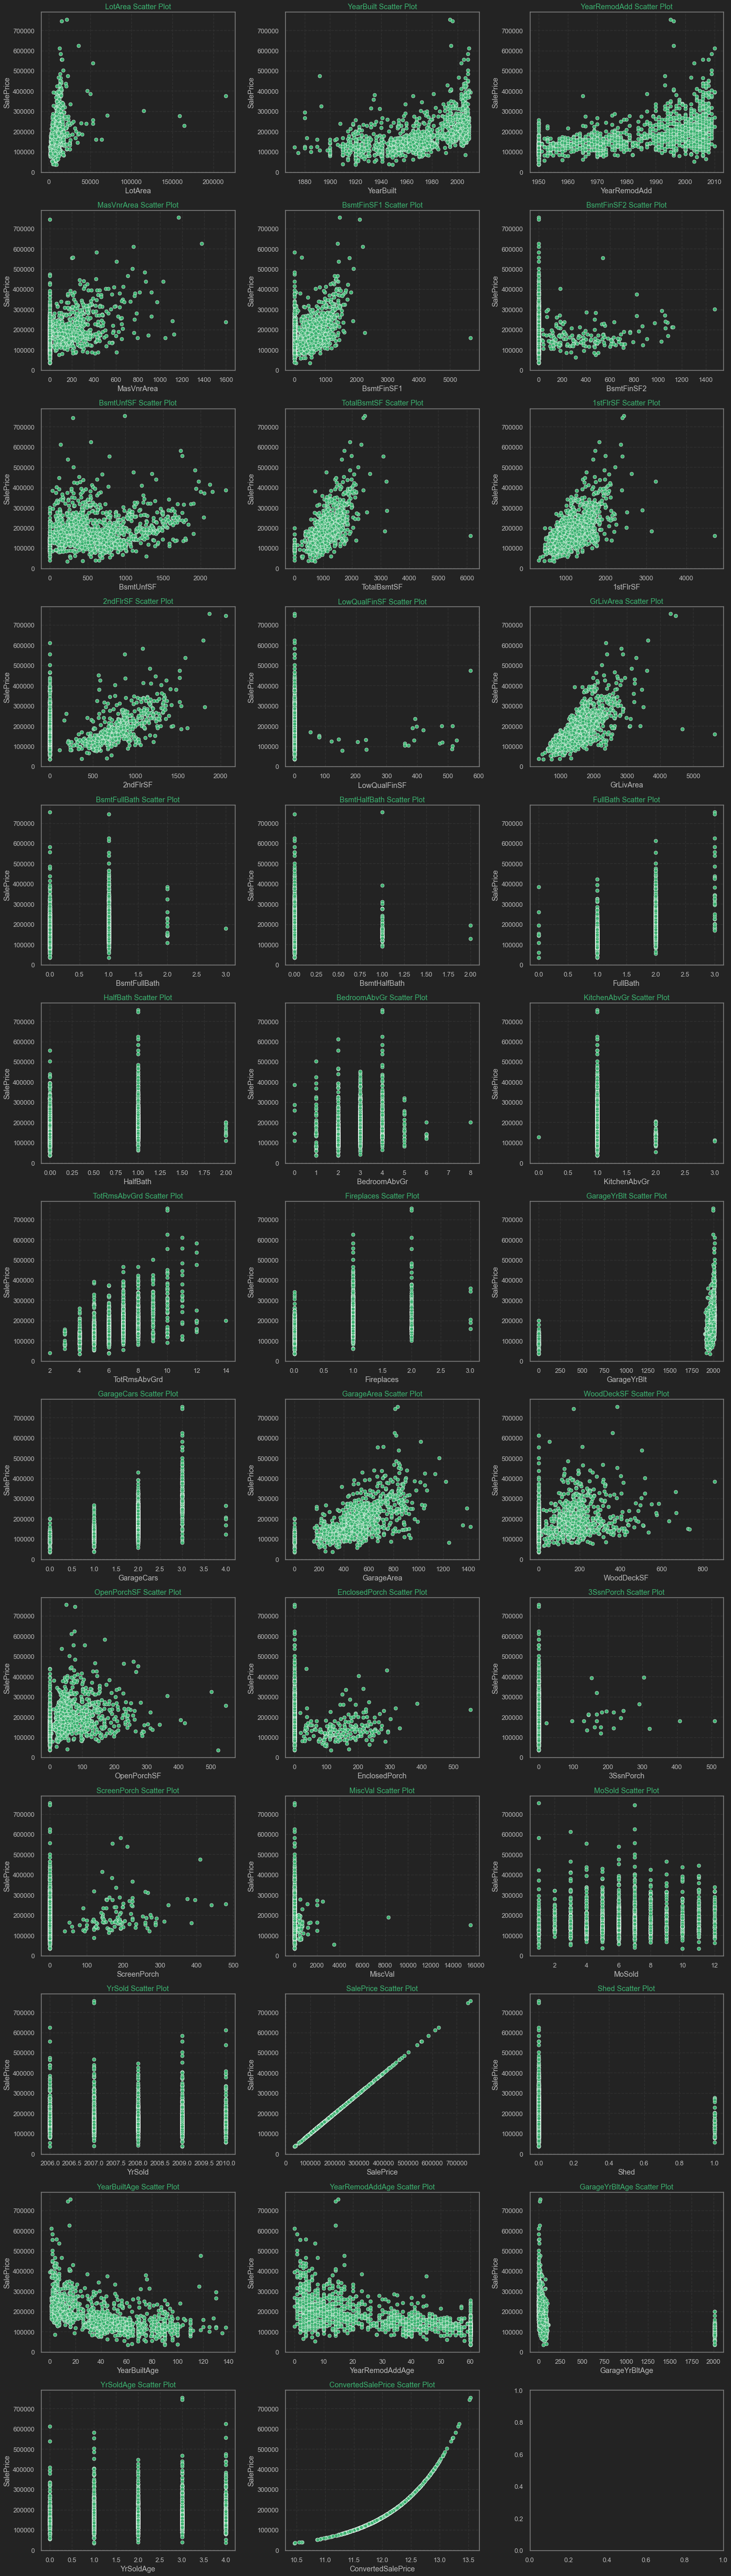

In [1570]:
plotting(numerical_columns, 'scatterplot')

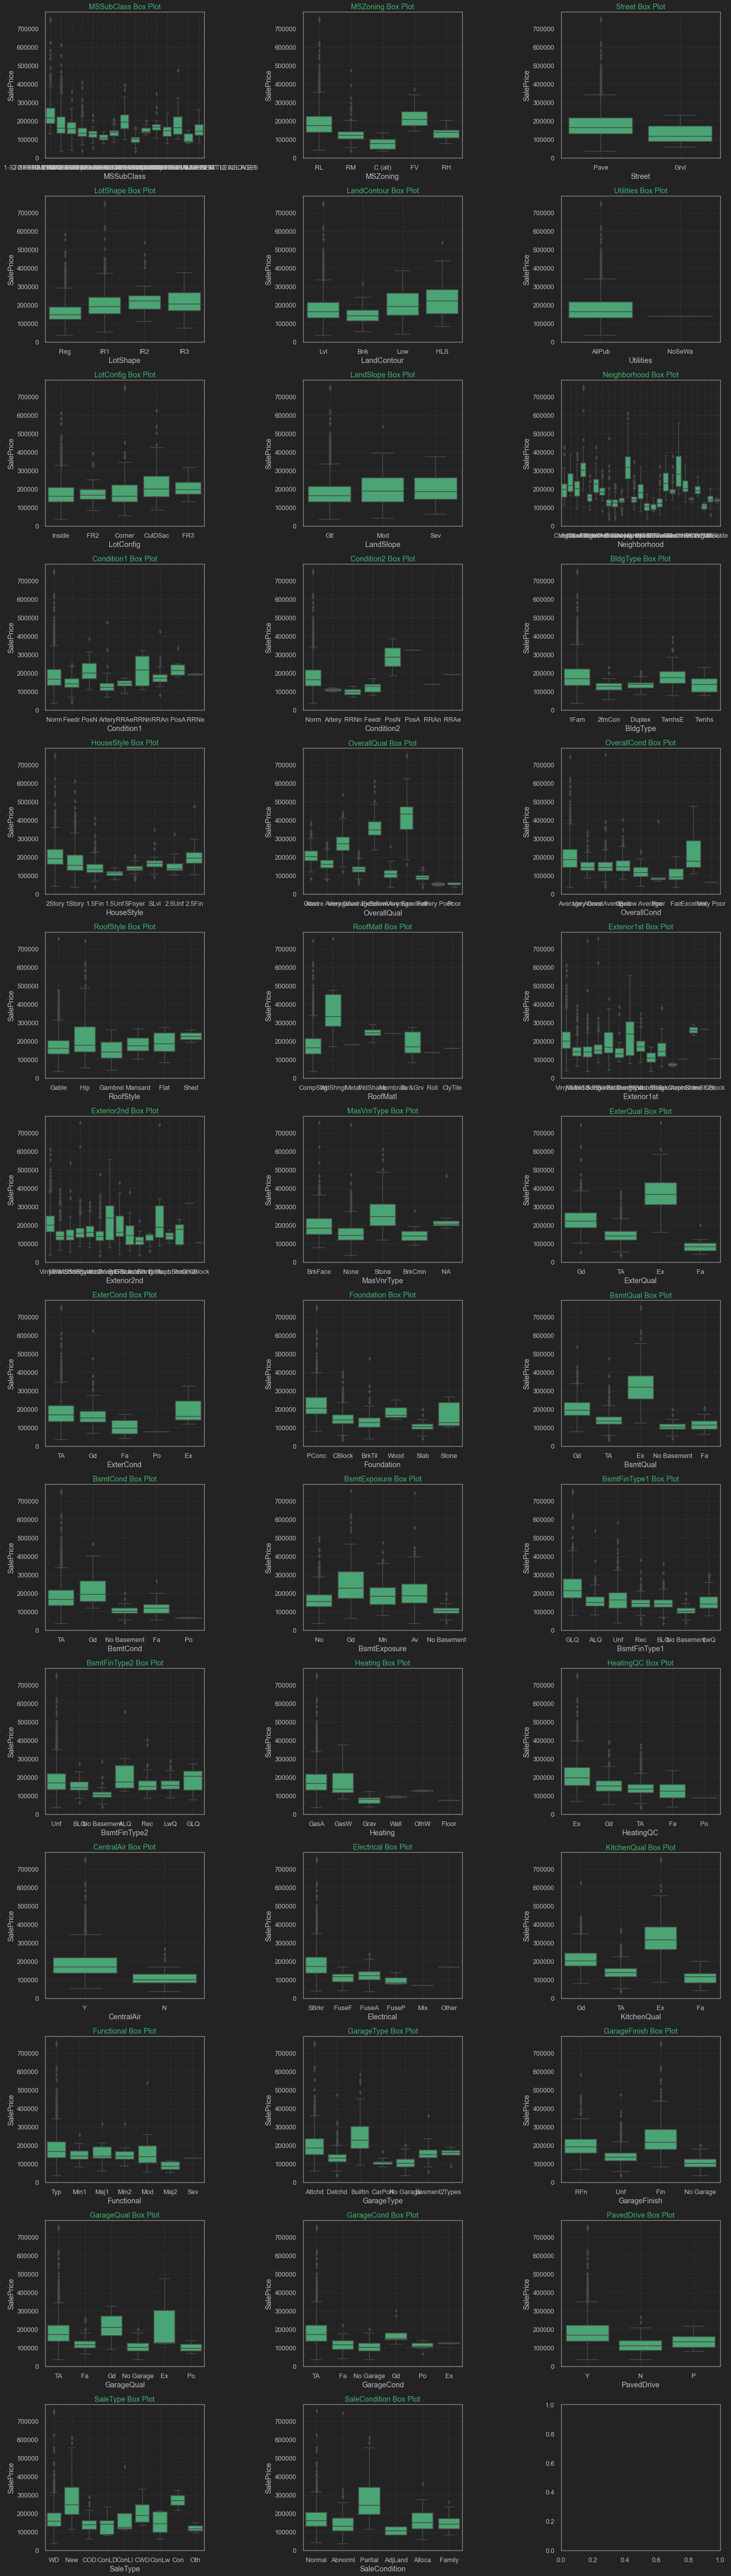

In [1571]:
plotting(categorical_columns, 'boxplot')

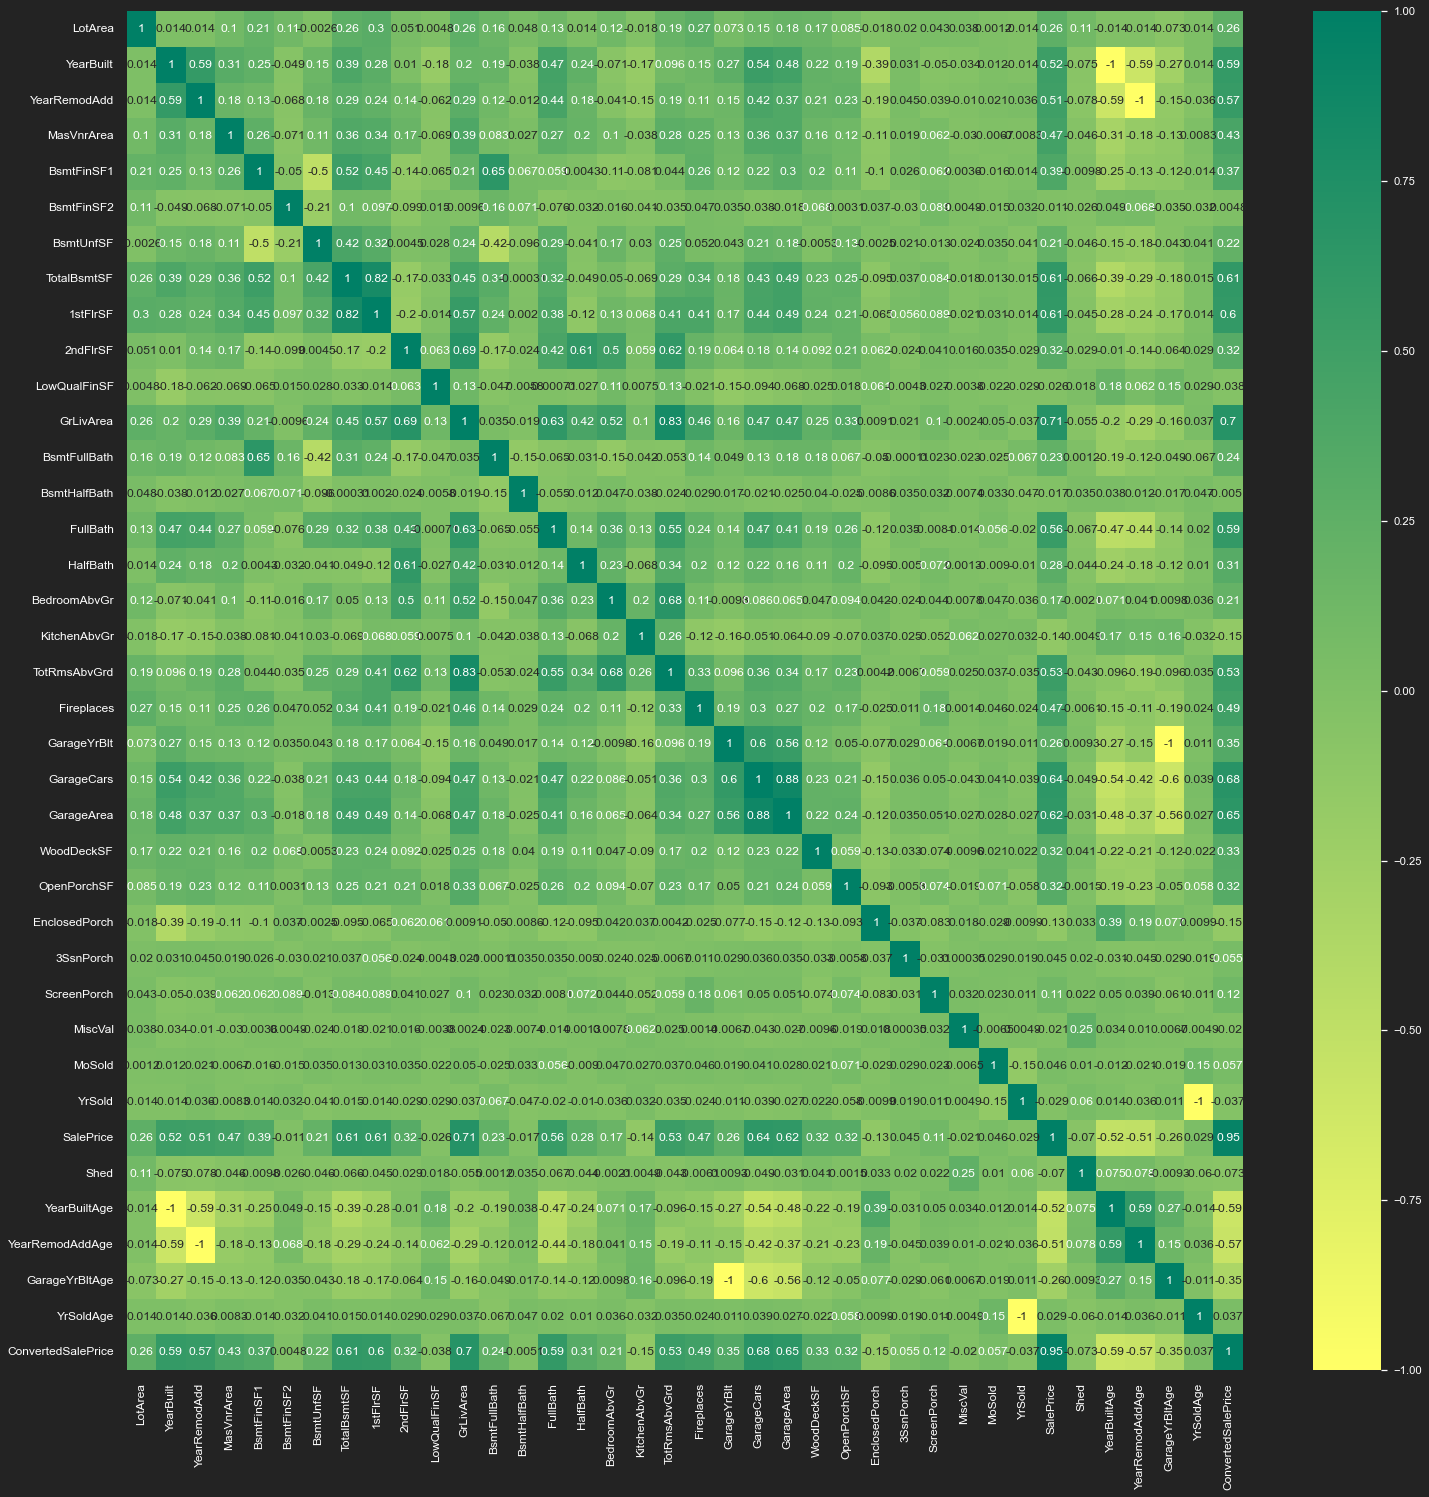

In [1572]:
customPlot() #plot theme

plt.figure(figsize=(25, 25)) #plot figure size
sns.set(font_scale=1.02) #plot font size

lc = house_data_1.corr() #correlation values for the loan data
ax = sns.heatmap(lc, cmap="summer_r", annot=True) #plotting a heatmap

cbar = ax.collections[0].colorbar #color bar
cbar.ax.tick_params(color='w', labelcolor='w') #color bar customization

for tick in [ax.axes.get_xticklabels(), ax.axes.get_yticklabels()]:
    for label in tick:
        label.set_color("white")
        label.set_fontsize("12")
plt.show() #to show plot

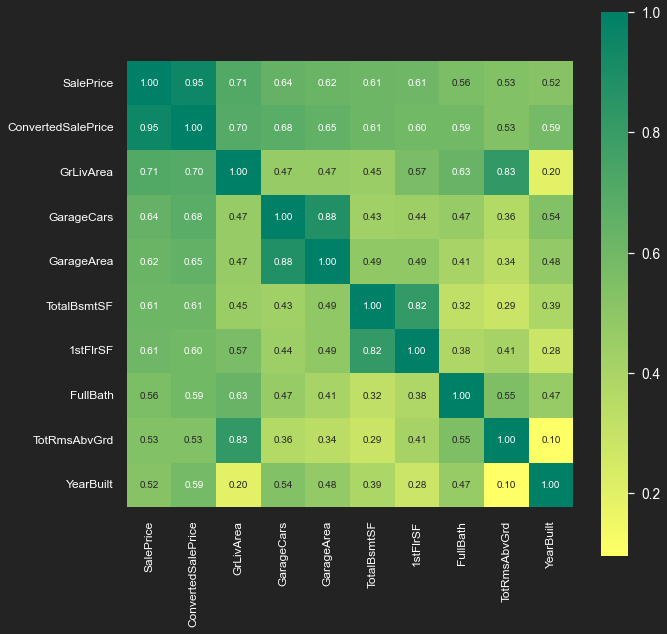

In [1573]:
customPlot() #plot theme

plt.figure(figsize=(10, 10)) #plot figure size
sns.set(font_scale=1.02) #plot font size

lc = house_data_1.corr() #correlation values for the loan data
k = 10
columns = lc.nlargest(k, 'SalePrice')['SalePrice'].index
column_map = np.corrcoef(house_data_1[columns].values.T)
sns.set(font_scale=1.25)
ax = sns.heatmap(column_map, cbar=True, square=True, fmt='.2f', annot_kws={'size': 10}, cmap="summer_r", yticklabels=columns.values, xticklabels=columns.values, annot=True) #plotting a heatmap

cbar = ax.collections[0].colorbar #color bar
cbar.ax.tick_params(color='w', labelcolor='w') #color bar customization

for tick in [ax.axes.get_xticklabels(), ax.axes.get_yticklabels()]:
    for label in tick:
        label.set_color("white")
        label.set_fontsize("12")
plt.show() #to show plot

**Observation:**
In the above correlation plot,
1. <code>GarageArea</code> and <code>GarageCars</code> are highly correlated.
3. <code>1stFlrSF</code> and <code>TotalBsmtSF</code> are highly correlated.
4. <code>GrLivArea</code> and <code>TotRmsAbvGrd</code> are highly correlated.

**Dropping highly correlated columns:**

In [1574]:
highlyCorrelatedColumns = ['GarageCars', '1stFlrSF', 'TotRmsAbvGrd']

#drop highly correlated columns
house_data_1.drop(highlyCorrelatedColumns, 1, inplace=True)

#shape after dropping highly correlated columns (1460 rows, 76 columns)
house_data_1.shape

(1460, 76)

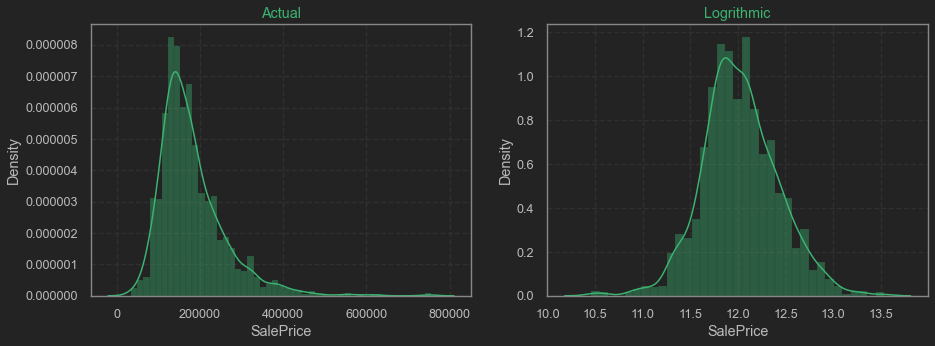

In [1575]:
#salePrice variable data analysis

customPlot() #plot theme

plt.figure(figsize=(15, 5))

plt.subplot(1, 2, 1)
sns.distplot(house_data_1['SalePrice'], color='mediumseagreen').ticklabel_format(useOffset=False, style='plain')
plt.title("Actual", color='mediumseagreen')

plt.grid(linestyle='--') #plot grid customization

plt.subplot(1, 2, 2)
sns.distplot(np.log(house_data_1['SalePrice']), color='mediumseagreen')
plt.title("Logrithmic", color='mediumseagreen')

plt.grid(linestyle='--') #plot grid customization

plt.show()

## Creating Dummy Variables

In [1576]:
#creating dummies for all categorical columns
house_data_2 = pd.get_dummies(data=house_data_1, columns=categorical_columns, drop_first=True) 

#exploring data
house_data_2.head()

,LotArea,YearBuilt,YearRemodAdd,MasVnrArea,BsmtFinSF1,BsmtFinSF2,BsmtUnfSF,TotalBsmtSF,2ndFlrSF,LowQualFinSF,...,SaleType_ConLI,SaleType_ConLw,SaleType_New,SaleType_Oth,SaleType_WD,SaleCondition_AdjLand,SaleCondition_Alloca,SaleCondition_Family,SaleCondition_Normal,SaleCondition_Partial
0,8450,2003,2003,196.00,706,0,150,856,854,0,...,0,0,0,0,1,0,0,0,1,0
1,9600,1976,1976,0.00,978,0,284,1262,0,0,...,0,0,0,0,1,0,0,0,1,0
2,11250,2001,2002,162.00,486,0,434,920,866,0,...,0,0,0,0,1,0,0,0,1,0
3,9550,1915,1970,0.00,216,0,540,756,756,0,...,0,0,0,0,1,0,0,0,0,0
4,14260,2000,2000,350.00,655,0,490,1145,1053,0,...,0,0,0,0,1,0,0,0,1,0


In [1577]:
#exploring columns after creating dummies
house_data_2.columns

Index(['LotArea', 'YearBuilt', 'YearRemodAdd', 'MasVnrArea', 'BsmtFinSF1',
       'BsmtFinSF2', 'BsmtUnfSF', 'TotalBsmtSF', '2ndFlrSF', 'LowQualFinSF',
       ...
       'SaleType_ConLI', 'SaleType_ConLw', 'SaleType_New', 'SaleType_Oth',
       'SaleType_WD', 'SaleCondition_AdjLand', 'SaleCondition_Alloca',
       'SaleCondition_Family', 'SaleCondition_Normal',
       'SaleCondition_Partial'],
      dtype='object', length=273)

## Splitting Train and Test Data

In [1578]:
#Adding features to X
X = house_data_2.drop(['SalePrice', 'ConvertedSalePrice'], axis=1)
y = house_data_2['ConvertedSalePrice']

In [1579]:
#splitting train and test data
X_train, X_test, y_train, y_test = train_test_split(X, y, train_size=0.7, test_size = 0.3, random_state=100)

In [1580]:
#shape of train data (1021 rows, 272 columns)
print('X_train shape:', X_train.shape)

#shape of test data (439 rows, 272 columns)
print('X_test shape:', X_test.shape)

X_train shape: (1021, 271)
X_test shape: (438, 271)


## Scaling Numerical Variables

In [1581]:
#scaling all numeric variables using standard scaler
scaler = StandardScaler() #using StandardScaler

columns = list(house_data_2.columns.values)
columns.remove('SalePrice')
columns.remove('ConvertedSalePrice')

house_data_2[columns] = scaler.fit_transform(house_data_2[columns]) #fitting train data
house_data_2.head()

,LotArea,YearBuilt,YearRemodAdd,MasVnrArea,BsmtFinSF1,BsmtFinSF2,BsmtUnfSF,TotalBsmtSF,2ndFlrSF,LowQualFinSF,...,SaleType_ConLI,SaleType_ConLw,SaleType_New,SaleType_Oth,SaleType_WD,SaleCondition_AdjLand,SaleCondition_Alloca,SaleCondition_Family,SaleCondition_Normal,SaleCondition_Partial
0,-0.21,1.05,0.88,0.51,0.58,-0.29,-0.94,-0.46,1.16,-0.12,...,-0.06,-0.06,-0.30,-0.05,0.39,-0.05,-0.09,-0.12,0.47,-0.31
1,-0.09,0.16,-0.43,-0.57,1.17,-0.29,-0.64,0.47,-0.80,-0.12,...,-0.06,-0.06,-0.30,-0.05,0.39,-0.05,-0.09,-0.12,0.47,-0.31
2,0.07,0.98,0.83,0.33,0.09,-0.29,-0.30,-0.31,1.19,-0.12,...,-0.06,-0.06,-0.30,-0.05,0.39,-0.05,-0.09,-0.12,0.47,-0.31
3,-0.10,-1.86,-0.72,-0.57,-0.50,-0.29,-0.06,-0.69,0.94,-0.12,...,-0.06,-0.06,-0.30,-0.05,0.39,-0.05,-0.09,-0.12,-2.14,-0.31
4,0.38,0.95,0.73,1.37,0.46,-0.29,-0.17,0.20,1.62,-0.12,...,-0.06,-0.06,-0.30,-0.05,0.39,-0.05,-0.09,-0.12,0.47,-0.31


In [1582]:
#exploring x train data after removing SalePrice column
X_train.head()

,LotArea,YearBuilt,YearRemodAdd,MasVnrArea,BsmtFinSF1,BsmtFinSF2,BsmtUnfSF,TotalBsmtSF,2ndFlrSF,LowQualFinSF,...,SaleType_ConLI,SaleType_ConLw,SaleType_New,SaleType_Oth,SaleType_WD,SaleCondition_AdjLand,SaleCondition_Alloca,SaleCondition_Family,SaleCondition_Normal,SaleCondition_Partial
210,5604,1925,1950,0.00,468,0,396,864,0,0,...,0,0,0,0,1,0,0,0,1,0
318,9900,1993,1993,256.00,987,0,360,1347,1274,0,...,0,0,0,0,1,0,0,0,1,0
239,8741,1945,1950,0.00,94,0,641,735,689,0,...,0,0,0,0,1,0,0,0,1,0
986,5310,1910,2003,0.00,0,0,485,485,634,0,...,0,0,0,0,1,0,0,0,1,0
1416,11340,1885,1950,0.00,0,0,777,777,1044,0,...,0,0,0,0,1,0,0,0,1,0


In [1583]:
#exploring x test data after removing SalePrice column
X_test.head()

,LotArea,YearBuilt,YearRemodAdd,MasVnrArea,BsmtFinSF1,BsmtFinSF2,BsmtUnfSF,TotalBsmtSF,2ndFlrSF,LowQualFinSF,...,SaleType_ConLI,SaleType_ConLw,SaleType_New,SaleType_Oth,SaleType_WD,SaleCondition_AdjLand,SaleCondition_Alloca,SaleCondition_Family,SaleCondition_Normal,SaleCondition_Partial
1436,9000,1971,1971,0.00,616,0,248,864,0,0,...,0,0,0,0,1,0,0,0,1,0
57,11645,2004,2004,0.00,0,0,860,860,860,0,...,0,0,0,0,1,0,0,0,1,0
780,7875,1995,1996,38.00,0,0,1237,1237,0,0,...,0,0,0,0,1,0,0,0,1,0
382,9245,2006,2006,0.00,0,0,939,939,858,0,...,0,0,0,0,1,0,0,0,1,0
1170,9880,1977,1977,0.00,522,0,574,1096,0,0,...,0,0,0,0,1,0,0,0,1,0


In [1584]:
#exploring y train data after assigning SalePrice column
y_train.head()

210    11.49
318    12.47
239    11.64
986    11.67
1416   11.72
Name: ConvertedSalePrice, dtype: float64

In [1585]:
#exploring y test data after assigning SalePrice column
y_test.head()

1436   11.70
57     12.19
780    12.08
382    12.27
1170   12.05
Name: ConvertedSalePrice, dtype: float64

## Model Building

In [1586]:
#list of alphas to tune
params = {'alpha': [0.0001, 0.001, 0.01, 0.05, 0.1, 
 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1.0, 2.0, 3.0, 
 4.0, 5.0, 6.0, 7.0, 8.0, 9.0, 10.0, 20, 50, 100, 500, 1000 ]}

#Applying Ridge
ridge = Ridge()

# cross validation
folds = 5
model_cv = GridSearchCV(estimator = ridge, 
                        param_grid = params, 
                        scoring= 'r2', 
                        cv = folds, 
                        return_train_score=True,
                        verbose = 1)            
model_cv.fit(X_train, y_train) 

Fitting 5 folds for each of 28 candidates, totalling 140 fits


GridSearchCV(cv=5, estimator=Ridge(),
             param_grid={'alpha': [0.0001, 0.001, 0.01, 0.05, 0.1, 0.2, 0.3,
                                   0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1.0, 2.0, 3.0,
                                   4.0, 5.0, 6.0, 7.0, 8.0, 9.0, 10.0, 20, 50,
                                   100, 500, 1000]},
             return_train_score=True, scoring='r2', verbose=1)

In [1587]:
#CV results
cv_results = pd.DataFrame(model_cv.cv_results_)
cv_results.head()

,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_alpha,params,split0_test_score,split1_test_score,split2_test_score,split3_test_score,...,mean_test_score,std_test_score,rank_test_score,split0_train_score,split1_train_score,split2_train_score,split3_train_score,split4_train_score,mean_train_score,std_train_score
0,0.01,0.00,0.00,0.00,0.00,{'alpha': 0.0001},0.89,0.67,0.81,0.58,...,0.77,0.13,28,0.97,0.97,0.97,0.96,0.96,0.97,0.00
1,0.01,0.00,0.00,0.00,0.00,{'alpha': 0.001},0.89,0.67,0.81,0.59,...,0.77,0.12,27,0.97,0.97,0.96,0.96,0.96,0.97,0.00
2,0.01,0.00,0.00,0.00,0.01,{'alpha': 0.01},0.89,0.67,0.82,0.68,...,0.79,0.10,24,0.97,0.97,0.96,0.96,0.96,0.96,0.00
3,0.01,0.00,0.00,0.00,0.05,{'alpha': 0.05},0.89,0.67,0.83,0.82,...,0.82,0.08,23,0.96,0.97,0.96,0.96,0.96,0.96,0.00
4,0.01,0.00,0.00,0.00,0.10,{'alpha': 0.1},0.88,0.68,0.83,0.85,...,0.83,0.08,21,0.96,0.97,0.96,0.96,0.95,0.96,0.00


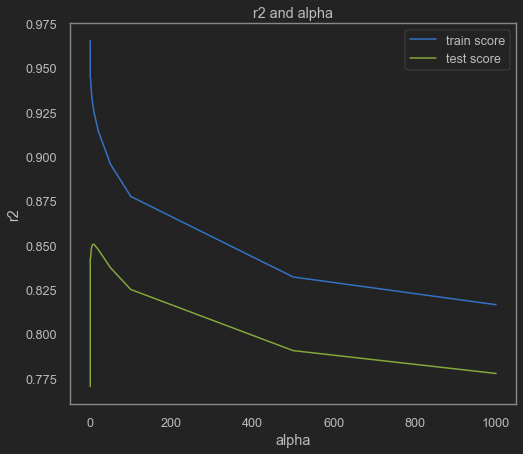

In [1588]:
customPlot()

# plotting mean test and train scoes with alpha 
cv_results['param_alpha'] = cv_results['param_alpha'].astype('int32')

# plotting
plt.plot(cv_results['param_alpha'], cv_results['mean_train_score'])
plt.plot(cv_results['param_alpha'], cv_results['mean_test_score'])
plt.xlabel('alpha')
plt.ylabel('r2')
plt.title("r2 and alpha")
plt.legend(['train score', 'test score'], loc='upper right')
plt.show()

In [1589]:
model_cv.best_params_

{'alpha': 8.0}

In [1590]:
#optimum alpha

alpha = 8.0
ridge = Ridge(alpha=alpha)

ridge.fit(X_train, y_train)
ridge.coef_

array([ 1.53042113e-06,  7.54370460e-04,  6.76415171e-04,  2.03972756e-05,
       -3.32567293e-05,  3.65312329e-05,  2.60487689e-06,  5.87937144e-06,
        1.81387172e-05, -1.29827165e-04,  2.40262302e-04,  4.95286550e-02,
        1.58030810e-02,  4.63184478e-02,  2.83376335e-02,  1.39911915e-02,
       -5.03261405e-02,  3.59703337e-02,  7.78993235e-06,  1.44308283e-04,
        1.15322737e-04,  5.50042977e-06,  8.93562070e-05,  2.29743453e-04,
        2.18882312e-04,  4.14026825e-07, -9.71223249e-05, -2.91757931e-03,
       -9.49570723e-03, -7.54370460e-04, -6.76415171e-04, -7.78993236e-06,
        2.91757931e-03,  1.47052822e-02, -5.43849240e-02,  3.92634445e-02,
        2.60970877e-03, -2.21837012e-03, -8.41487061e-03,  3.05281278e-02,
        6.55631817e-02, -3.24309492e-02, -6.12730000e-02,  1.15056666e-02,
       -3.95602746e-02,  2.22665316e-02,  1.98936602e-03,  6.39327431e-02,
        4.92998188e-02,  7.77160099e-02,  3.68454740e-02,  2.67236326e-02,
        2.51140927e-02, -

In [1591]:
ridge.score(X_train,y_train)

0.9223684306482623

In [1592]:
ridge.score(X_test,y_test)

0.8838561275680571

In [1593]:
#Ridge Model
ridge = Ridge(alpha=model_cv.best_params_['alpha'])
ridge.fit(X_train, y_train)

y_pred_ridge_train=ridge.predict(X_train)
print('Train R2 Square : ', round(r2_score(y_train, y_pred_ridge_train),2))

y_pred_ridge_test=ridge.predict(X_test)
print('Test R2 Square : ', round(r2_score(y_test, y_pred_ridge_test),2))

Train R2 Square :  0.92
Test R2 Square :  0.88


In [1594]:
# Ridge model parameters
model_parameters = list(sorted(ridge.coef_))
model_parameters.insert(0, ridge.intercept_)
model_parameters = [round(x, 3) for x in model_parameters]
cols = X.columns
cols = cols.insert(0, "constant")
list(zip(cols, model_parameters))

[('constant', 14.116),
 ('LotArea', -0.119),
 ('YearBuilt', -0.101),
 ('YearRemodAdd', -0.094),
 ('MasVnrArea', -0.089),
 ('BsmtFinSF1', -0.077),
 ('BsmtFinSF2', -0.069),
 ('BsmtUnfSF', -0.066),
 ('TotalBsmtSF', -0.061),
 ('2ndFlrSF', -0.06),
 ('LowQualFinSF', -0.057),
 ('GrLivArea', -0.055),
 ('BsmtFullBath', -0.054),
 ('BsmtHalfBath', -0.054),
 ('FullBath', -0.051),
 ('HalfBath', -0.05),
 ('BedroomAbvGr', -0.05),
 ('KitchenAbvGr', -0.05),
 ('Fireplaces', -0.05),
 ('GarageYrBlt', -0.05),
 ('GarageArea', -0.047),
 ('WoodDeckSF', -0.044),
 ('OpenPorchSF', -0.042),
 ('EnclosedPorch', -0.041),
 ('3SsnPorch', -0.04),
 ('ScreenPorch', -0.04),
 ('MiscVal', -0.039),
 ('MoSold', -0.037),
 ('YrSold', -0.032),
 ('Shed', -0.032),
 ('YearBuiltAge', -0.032),
 ('YearRemodAddAge', -0.032),
 ('GarageYrBltAge', -0.031),
 ('YrSoldAge', -0.029),
 ('MSSubClass_1-1/2 STORY FINISHED ALL AGES', -0.029),
 ('MSSubClass_1-STORY 1945 & OLDER', -0.029),
 ('MSSubClass_1-STORY 1946 & NEWER ALL STYLES', -0.029),
 ('

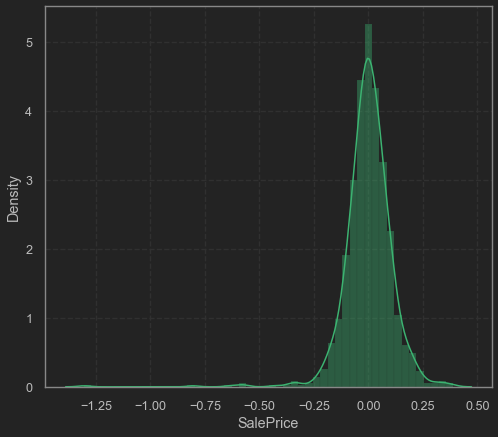

In [1595]:
customPlot()

ax = sns.distplot((y_train-y_pred_ridge_train), color='mediumseagreen', bins=50)
ax.grid(linestyle='--') #plot grid line customization
ax.set_xlabel('SalePrice')
plt.show()

In [1596]:
#Applying Lasso
lasso = Lasso()

# cross validation
folds = 5
model_cv = GridSearchCV(estimator = lasso, param_grid = params, scoring= 'neg_mean_absolute_error', 
                        cv = folds, return_train_score=True, verbose = 1)            

model_cv.fit(X_train, y_train) 

Fitting 5 folds for each of 28 candidates, totalling 140 fits


GridSearchCV(cv=5, estimator=Lasso(),
             param_grid={'alpha': [0.0001, 0.001, 0.01, 0.05, 0.1, 0.2, 0.3,
                                   0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1.0, 2.0, 3.0,
                                   4.0, 5.0, 6.0, 7.0, 8.0, 9.0, 10.0, 20, 50,
                                   100, 500, 1000]},
             return_train_score=True, scoring='neg_mean_absolute_error',
             verbose=1)

In [1597]:
#CV results
cv_results = pd.DataFrame(model_cv.cv_results_)
cv_results[['params', 'mean_train_score', 'mean_test_score']].head()

,params,mean_train_score,mean_test_score
0,{'alpha': 0.0001},-0.06,-0.09
1,{'alpha': 0.001},-0.08,-0.09
2,{'alpha': 0.01},-0.11,-0.12
3,{'alpha': 0.05},-0.12,-0.12
4,{'alpha': 0.1},-0.12,-0.12


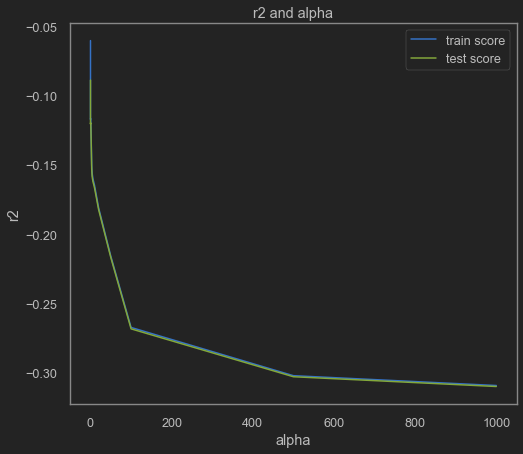

In [1598]:
# plotting mean test and train scoes with alpha 
cv_results['param_alpha'] = cv_results['param_alpha'].astype('float32')

# plotting
plt.plot(cv_results['param_alpha'], cv_results['mean_train_score'])
plt.plot(cv_results['param_alpha'], cv_results['mean_test_score'])
plt.xlabel('alpha')
plt.ylabel('r2')

plt.title("r2 and alpha")
plt.legend(['train score', 'test score'], loc='upper right')
plt.show()

In [1599]:
model_cv.best_params_

{'alpha': 0.0001}

In [1600]:
#optimum alpha

alpha = 0.0001

lasso = Lasso(alpha=alpha)
        
lasso.fit(X_train, y_train) 

Lasso(alpha=0.0001)

In [1601]:
lasso.score(X_train,y_train)

0.9505094800517908

In [1602]:
lasso.score(X_test,y_test)

0.8749591947154152

In [1603]:
#Lasso Model
lasso = Lasso(alpha=model_cv.best_params_['alpha'])
lasso.fit(X_train, y_train)

y_pred_lasso_train=lasso.predict(X_train)
print('Train R2 Square : ', round(r2_score(y_train, y_pred_lasso_train),2))

y_pred_lasso_test=lasso.predict(X_test)
print('Test R2 Square : ', round(r2_score(y_test, y_pred_lasso_test),2))

Train R2 Square :  0.95
Test R2 Square :  0.87


In [1604]:
#Lasso model parameters
model_parameters = list(sorted(lasso.coef_))
model_parameters.insert(0, lasso.intercept_)
model_parameters = [round(x, 3) for x in model_parameters]
cols = X.columns
cols = cols.insert(0, "constant")
list((zip(cols, model_parameters)))

[('constant', 4.023),
 ('LotArea', -1.213),
 ('YearBuilt', -0.331),
 ('YearRemodAdd', -0.197),
 ('MasVnrArea', -0.168),
 ('BsmtFinSF1', -0.157),
 ('BsmtFinSF2', -0.127),
 ('BsmtUnfSF', -0.1),
 ('TotalBsmtSF', -0.088),
 ('2ndFlrSF', -0.086),
 ('LowQualFinSF', -0.081),
 ('GrLivArea', -0.08),
 ('BsmtFullBath', -0.07),
 ('BsmtHalfBath', -0.065),
 ('FullBath', -0.062),
 ('HalfBath', -0.059),
 ('BedroomAbvGr', -0.058),
 ('KitchenAbvGr', -0.057),
 ('Fireplaces', -0.056),
 ('GarageYrBlt', -0.054),
 ('GarageArea', -0.051),
 ('WoodDeckSF', -0.051),
 ('OpenPorchSF', -0.05),
 ('EnclosedPorch', -0.049),
 ('3SsnPorch', -0.048),
 ('ScreenPorch', -0.048),
 ('MiscVal', -0.048),
 ('MoSold', -0.047),
 ('YrSold', -0.046),
 ('Shed', -0.046),
 ('YearBuiltAge', -0.045),
 ('YearRemodAddAge', -0.042),
 ('GarageYrBltAge', -0.041),
 ('YrSoldAge', -0.041),
 ('MSSubClass_1-1/2 STORY FINISHED ALL AGES', -0.041),
 ('MSSubClass_1-STORY 1945 & OLDER', -0.034),
 ('MSSubClass_1-STORY 1946 & NEWER ALL STYLES', -0.033),
 

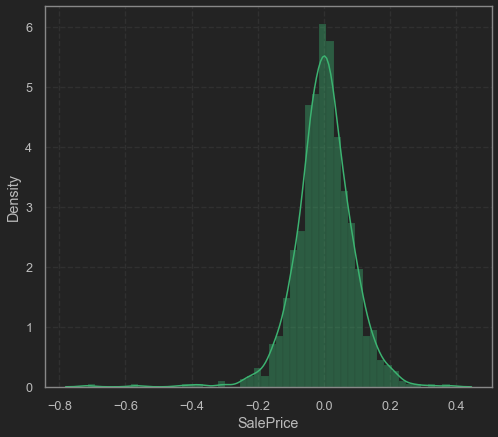

In [1605]:
customPlot()

ax = sns.distplot((y_train-y_pred_lasso_train), color='mediumseagreen', bins=50)
ax.grid(linestyle='--') #plot grid line customization
ax.set_xlabel('SalePrice')
plt.show()

# Conclusion

1. Ridge => Train = 0.92 Test = 0.88
2. Lasso => Train = 0.90 Test = 0.87

- In Ridge, Significant variables are
    - ('SaleCondition_AdjLand', 0.078),
    - ('SaleCondition_Alloca', 0.092),
    - ('SaleCondition_Family', 0.094),
    - ('SaleCondition_Normal', 0.095),
    - ('SaleCondition_Partial', 0.147)

- In Lasso, Significant variables are
    - ('SaleCondition_AdjLand', 1.148),
    - ('SaleCondition_Alloca', 1.158),
    - ('SaleCondition_Family', 1.161),
    - ('SaleCondition_Normal', 1.225),
    - ('SaleCondition_Partial', 1.301)

**Hence, property value depends on these and properties should be bought according to Sale Price and Conditions.**